In [1]:
import xarray as xr
import rioxarray as rxr
import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt

from fft_unwrap import unwrap_phase_fft
from coherence import calculate_coherence_fast

%load_ext autoreload
%autoreload 2

In [2]:
fn_1 = "/home/jehayes/sar_dump/opera_cslc/asc/OPERA_L2_CSLC-S1_T124-264305-IW2_20180309T042958Z_20240428T201954Z_S1B_VV_v1.1.h5"
fn_2 = '/home/jehayes/sar_dump/opera_cslc/asc/OPERA_L2_CSLC-S1_T124-264305-IW2_20180514T043042Z_20240429T160341Z_S1A_VV_v1.1.h5'

dsR = xr.open_dataset(fn_1,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
# start time of the SAR acquisition in UTC
tR = pd.to_datetime(xr.open_dataset(fn_1, 
                                    group='identification')['zero_doppler_start_time'].data.astype('U')) # Unicode string format
dsS = xr.open_dataset(fn_2,
                      group='data',
                      engine='h5netcdf')['VV'].rename(dict(x_coordinates='x', y_coordinates='y'))
tS = pd.to_datetime(xr.open_dataset(fn_2, group='identification')['zero_doppler_start_time'].data.astype('U'))
print(tR, tS)

2018-03-09 04:29:58.016365 2018-05-14 04:30:42.321313


In [3]:
with h5py.File(fn_1, 'r') as f:
        if 'data/projection' in f:
            crs = f['data/projection'][()]
        else:
            # Default to WGS84 if not specified
            crs = 'EPSG:4326'
print(crs)
dsR = dsR.rio.write_crs(crs)
dsS = dsS.rio.write_crs(crs)

32605


In [4]:
window_size = 7
min_valid = 0.5
da_coh = calculate_coherence_fast(dsR, dsS, window=window_size, min_valid_ratio=min_valid)

In [5]:
# Wrapped interferogram Calculation
# multiply dsR (reference image) by the complex conjugate of dsS (secondary image)
ifg = dsR * np.conj(dsS)
ifg.attrs['reference'] = tR
ifg.attrs['secondary'] = tS
da = xr.apply_ufunc(np.angle, ifg)
ds = da.to_dataset(name='phase').rio.write_crs(dsR.rio.crs)

def scale_amplitude(da):
    ''' decible scale for viz'''
    return 20*np.log10(np.abs(da))
ds['amplitude'] = xr.apply_ufunc(scale_amplitude, ifg)

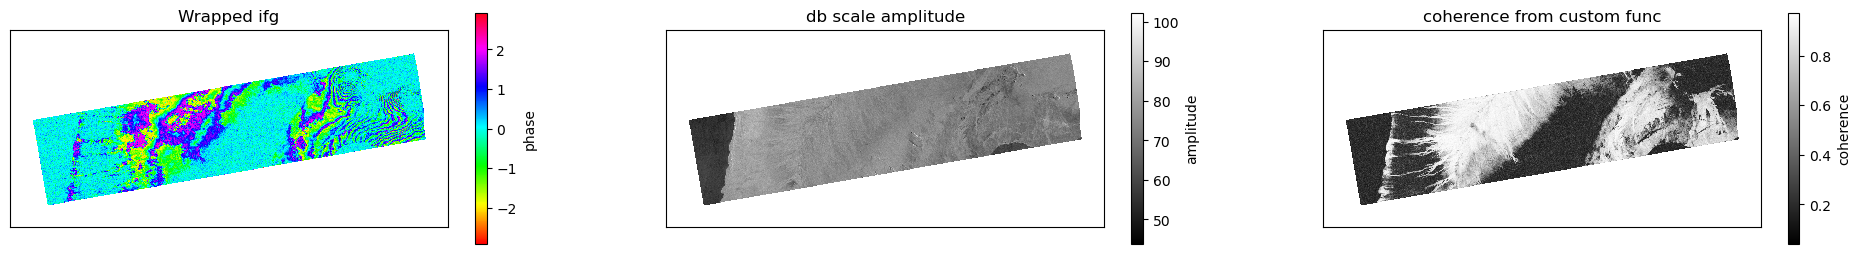

In [6]:
# 80meter posting for faster plots
nx=16
ny=8 

fig,axs = plt.subplots(1,3,figsize=(24,3))
ds.phase.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[0])
axs[0].set_title("Wrapped ifg")
ds.amplitude.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='gray', ax=axs[1])
axs[1].set_title("db scale amplitude")
da_coh.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(ax=axs[2], cmap='gray')
axs[2].set_title("coherence from custom func")

for ax in axs:
    ax.set(yticks=[],
        xticks=[],
        ylabel="",
        xlabel="")
    ax.set_aspect('equal')

In [ ]:
%%time
# option to coarsen, but we won't
nx = 1
ny = 1
wrapped_phase_da = ds.phase.coarsen(x=nx, y=ny, boundary='trim').mean()
wrapped_phase_np = wrapped_phase_da.values

# Unwrap the phase using our custom FFT-based function
unwrapped_np = unwrap_phase_fft(wrapped_phase_np)

# Convert back to an xarray DataArray with matching coordinates
unwrapped_da = xr.DataArray(unwrapped_np, dims=wrapped_phase_da.dims, 
                            coords=wrapped_phase_da.coords).rio.write_crs(dsR.rio.crs)
unwrapped_da = unwrapped_da.where(~np.isnan(ds.phase))

CPU times: user 39.7 s, sys: 15.1 s, total: 54.8 s
Wall time: 54.5 s


In [13]:
da_coh = da_coh.rio.reproject_match(unwrapped_da)
# reference anchoring, average unwrapped phase values over all pixels with coherence >.98
stable_mask = da_coh.values >= 0.99   # 2D boolean array
# corresponding unwrapped‐phase values
stable_phase_values = unwrapped_da.values[stable_mask]
# median
phi0_median = np.median(stable_phase_values)
# Subtract that median from the entire unwrapped field
unwrapped_da_refed = unwrapped_da - phi0_median
phi0_median

np.float64(2.6415804760065456)

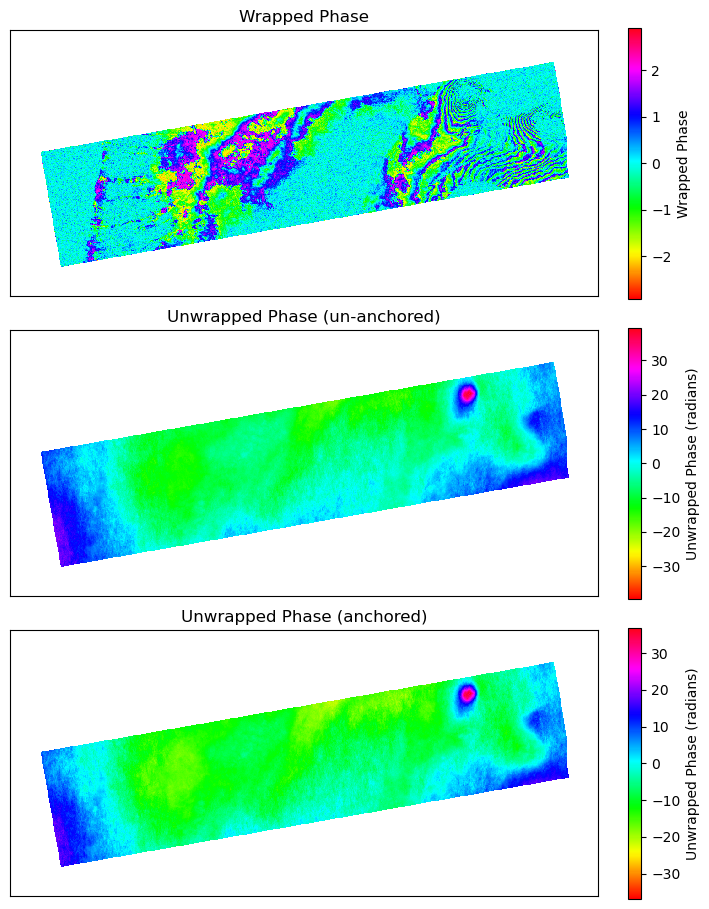

In [14]:
nx=16
ny=8
f, axs = plt.subplots(3,1,figsize=(7,9), constrained_layout=True,
                      sharex=True, sharey=True)
ds.phase.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[0],
                                                                           cbar_kwargs={'label': 'Wrapped Phase'})
axs[0].set_title('Wrapped Phase')

unwrapped_da.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[1],
                                                                     cbar_kwargs={'label': 'Unwrapped Phase (radians)'})
axs[1].set_title('Unwrapped Phase (un-anchored)')

unwrapped_da_refed.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[2],
                                                                     cbar_kwargs={'label': 'Unwrapped Phase (radians)'})
axs[2].set_title('Unwrapped Phase (anchored)')

for ax in axs:
    ax.set(yticks=[],
        xticks=[],
        ylabel="",
        xlabel="")
    ax.set_aspect('equal')

In [ ]:
# radar wavelength in meters
with h5py.File(fn_2, 'r') as f:
    wavelength = f['metadata']['processing_information']['input_burst_metadata']['wavelength'][()]
# Convert the unwrapped phase (in radians) to displacement (in meters)
# d = unwrapped_phase * (wavelength / (4*pi))
da_displacement_los = -unwrapped_da_refed * (wavelength / (4 * np.pi))
ds_displacement_los = da_displacement_los.to_dataset(name='displacement_los')
with h5py.File(fn_2, 'r') as f:
    crs = f['/metadata/noise_information/projection'][()]
da_displacement_los = da_displacement_los.rio.write_crs(crs)

In [ ]:
fn_test = "/home/jehayes/opera_disp_samples/kil_2018_04/data/OPERA_L3_DISP-S1_IW_F33039_VV_20180309T042958Z_20180514T043042Z_v1.1_20250216T074143Z.nc"
#fn_test = "/home/jehayes/opera_disp_samples/kil_2018_04/data/OPERA_L3_DISP-S1_IW_F33039_VV_20180309T042958Z_20180520T043000Z_v1.1_20250216T074143Z.nc"
ds_test = xr.open_dataset(fn_test).rio.write_crs(crs)

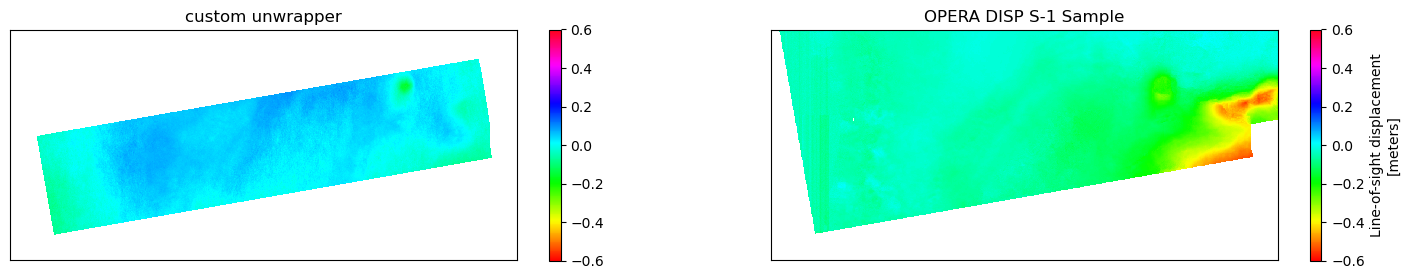

In [17]:
nx=4
ny=2 

fig,axes = plt.subplots(1,2,figsize=(18,3))
ax=axes[0]
#ds_test.displacement.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='Grays', ax=ax)
da_displacement_los.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=ax,
                                                                           vmin=-.6, vmax=.6)
ax.set_title("custom unwrapper")

ax=axes[1]
#da_displacement_los.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='Grays', ax=ax)
ds_test.displacement.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=ax,
                                                                            vmin=-.6, vmax=.6)
xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("OPERA DISP S-1 Sample")


for ax in axes:
    ax.set(yticks=[],
        xticks=[],
        ylabel="",
        xlabel="")
    ax.set_aspect('equal')

Original

---

Testing ground

In [8]:
from fft_unwrap_bridge import unwrap_phase_fft_bridge

In [9]:
unwrap_phase_fft_bridge?

Signature:
unwrap_phase_fft_bridge(
    wrapped,
    window=5,
    threshold_factor=1.5,
    min_region_size=100,
    bridge_window=16,
    verbose=True,
)
Docstring:
Unwrap a 2D wrapped interferometric phase image with fast Poisson-based least-squares
plus a lightweight bridging correction. This version:

  - **Enlarges sampling window** (bridge_window=16) to exceed the characteristic
    decorrelation scale (e.g., >100 m for Kīlauea 2018 eruption scene) so that
    phase-difference estimates average over coherent patches spanning lava flows.
  - **Trimmed-mean thresholds** ([15, 85] percentile) to reflect heavy
    noise/outlier tails induced by decorrelated lava, crater walls, and fumaroles.
  - **Linear ramp removal/add-back** on the largest reliable region to decouple
    long-wavelength volcanic deformation signals (meters/day) from integer-cycle offsets.

**These settings are not universal**—they must be tuned to the site’s coherence field
and deformation amplitude. For example,

In [10]:
%%time
# option to coarsen, but we won't
nx = 1
ny = 1

wrapped_phase_da = ds.phase.coarsen(x=nx, y=ny, boundary='trim').mean()
wrapped_phase_np = wrapped_phase_da.values

# updated func for testing
unwrapped_np_2 = unwrap_phase_fft_bridge(wrapped_phase_np)

unwrapped_da_2 = xr.DataArray(unwrapped_np_2, dims=wrapped_phase_da.dims, 
                            coords=wrapped_phase_da.coords).rio.write_crs(dsR.rio.crs)
unwrapped_da_2 = unwrapped_da_2.where(~np.isnan(ds.phase))

NaN replacement: 2.669s
Quality filtering: 21.250s
Poisson solve: 31.963s
Bridging: 23.468s
Total: 79.351s
CPU times: user 1min 6s, sys: 17.4 s, total: 1min 23s
Wall time: 1min 18s


In [11]:
da_coh_2 = da_coh.rio.reproject_match(unwrapped_da_2)
# reference anchoring, average unwrapped phase values over all pixels with coherence >.99
stable_mask_2 = da_coh_2.values >= 0.99   # 2D boolean array
# corresponding unwrapped‐phase values
stable_phase_values_2 = unwrapped_da_2.values[stable_mask_2]
# median
phi0_median_2 = np.median(stable_phase_values_2)
# Subtract that median from the entire unwrapped field
unwrapped_da_refed_2 = unwrapped_da_2 - phi0_median_2
phi0_median_2

np.float64(-9.992920934259603)

In [12]:
# Fsingle pixel with maximum coherence
max_coh_index = np.nanargmax(da_coh_2.values)
max_coh_coords = np.unravel_index(max_coh_index, da_coh_2.shape)
phi0_max = unwrapped_da_2.values[max_coh_coords]
unwrapped_da_refed_2 = unwrapped_da_2 - phi0_max
print(f"Reference phase value (from max coherence pixel): {phi0_max}")

Reference phase value (from max coherence pixel): -9.992920934259603


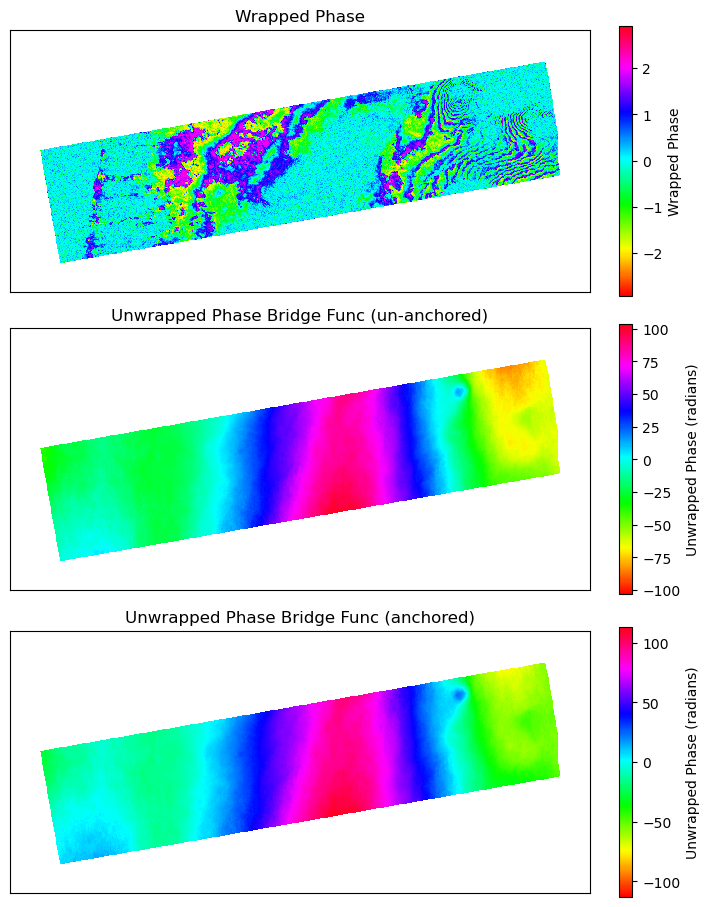

In [13]:
nx=16
ny=8
f, axs = plt.subplots(3,1,figsize=(7,9), constrained_layout=True,
                      sharex=True, sharey=True)
ds.phase.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[0],
                                                                           cbar_kwargs={'label': 'Wrapped Phase'})
axs[0].set_title('Wrapped Phase')

unwrapped_da_2.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[1],
                                                                     cbar_kwargs={'label': 'Unwrapped Phase (radians)'})
axs[1].set_title('Unwrapped Phase Bridge Func (un-anchored)')

unwrapped_da_refed_2.coarsen(x=nx, y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=axs[2],
                                                                     cbar_kwargs={'label': 'Unwrapped Phase (radians)'})
axs[2].set_title('Unwrapped Phase Bridge Func (anchored)')

for ax in axs:
    ax.set(yticks=[],
        xticks=[],
        ylabel="",
        xlabel="")
    ax.set_aspect('equal')

In [14]:
# radar wavelength in meters
with h5py.File(fn_2, 'r') as f:
    wavelength = f['metadata']['processing_information']['input_burst_metadata']['wavelength'][()]
# Convert the unwrapped phase (in radians) to displacement (in meters)
# d = unwrapped_phase * (wavelength / (4*pi))
da_displacement_los_2 = -unwrapped_da_refed_2 * (wavelength / (4 * np.pi))
ds_displacement_los_2 = da_displacement_los_2.to_dataset(name='displacement_los')
with h5py.File(fn_2, 'r') as f:
    crs = f['/metadata/noise_information/projection'][()]
da_displacement_los_2 = da_displacement_los_2.rio.write_crs(crs)
fn_test = "/home/jehayes/opera_disp_samples/kil_2018_04/data/OPERA_L3_DISP-S1_IW_F33039_VV_20180309T042958Z_20180514T043042Z_v1.1_20250216T074143Z.nc"
#fn_test = "/home/jehayes/opera_disp_samples/kil_2018_04/data/OPERA_L3_DISP-S1_IW_F33039_VV_20180309T042958Z_20180520T043000Z_v1.1_20250216T074143Z.nc"
ds_test = xr.open_dataset(fn_test).rio.write_crs(crs)

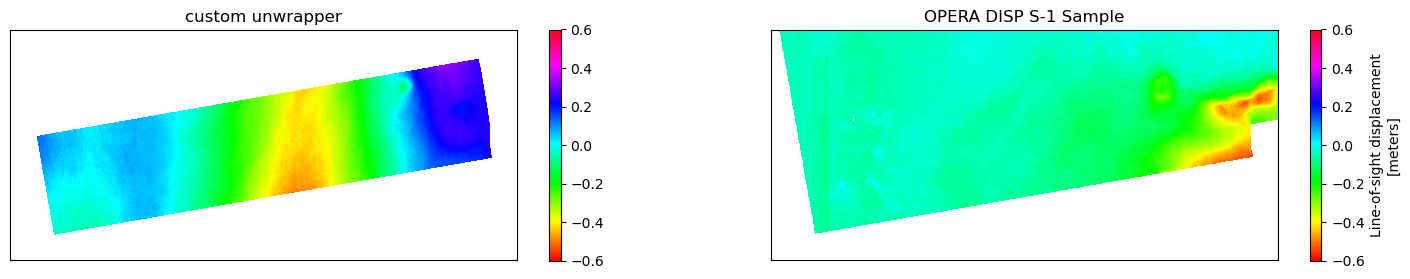

In [15]:
nx=4
ny=2 

fig,axes = plt.subplots(1,2,figsize=(18,3))
ax=axes[0]
#ds_test.displacement.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='Grays', ax=ax)
da_displacement_los_2.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=ax,
                                                                           vmin=-.6, vmax=.6)
ax.set_title("custom unwrapper")

ax=axes[1]
#da_displacement_los.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='Grays', ax=ax)
ds_test.displacement.coarsen(x=nx,y=ny, boundary='trim').mean().plot.imshow(cmap='hsv', ax=ax,
                                                                            vmin=-.6, vmax=.6)
xlim = axes[0].get_xlim()
ylim = axes[0].get_ylim()
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_title("OPERA DISP S-1 Sample")


for ax in axes:
    ax.set(yticks=[],
        xticks=[],
        ylabel="",
        xlabel="")
    ax.set_aspect('equal')